# Analyse textuelle 

A partir du tableau *tweets_fusionnes_def.csv*, qui indique pour chaque tweet s'il est catégorisé comme violent ou non, on a mené une analyse textuelle sur le contenu des tweets.
Cette dernière a pour objectif d'identifier si certains mots sont de plus en plus utilisés dans le temps, et si on peut voir se dégager une tendance au long de l'année 2024. En outre nous avons aussi décidé de comparer le langage des tweets dits violents et de ceux dits non violents, afin de voir si des mots ressortent plus dans un groupe que l'autre. On utilise exclusivement le modèle `plotly`.

L'analyse textuelle requiert une étape préliminaire de transformation du contenu des tweets en un ensemble d'information synthétique : avec le module `SpaCy`on supprime tout d'abord les éléments qui transmettent peu ou pas d'informations (signes de ponctuation, émoticônes, liens, hashtags). On supprime également les *stopwords* dont la liste existe déjà au préalable dans le module, on ajoute également une liste de mots personnalisés qui n'auront pas d'intérêt dans le contexte du projet, notamment les mots de la requête. Finalement, pour traiter du sens de chaque mot, et ne pas distinguer un verbe et ce même verbe + *ing* par exemple, on lemmatise chaque mot, ce qui est toujours permis par `SpaCy`.

In [1]:
!pip install pandas
!pip install spacy
!pip install plotly
!pip install wordcloud
!pip install nbformat
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import spacy
from collections import Counter
import nltk
from nltk.probability import FreqDist
import plotly.express as px
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

**Etape 1 : Tokenisation des tweets et suppression des stopwords**

In [3]:
# Chargement des données
file_path = os.path.join('..', 'data_fin', 'tweets_fusionnes_def.csv')
df = pd.read_csv(file_path)

# Liste de stopwords supplémentaires
custom_stopwords_1 = {"https", "twitter", "elon", "musk", "people","quit","leave","stay", "like", "amp", "com", "user", "retweet", "go", "delete", "account","not"}

def clean_and_tokenize_spacy(df, custom_stopwords):
    """
    Nettoie et tokenize le contenu des tweets en supprimant les stopwords et en lemmatisant.
    
    :param df: DataFrame contenant les tweets
    :param custom_stopwords: Ensemble de mots personnalisés à exclure
    :return: DataFrame avec une nouvelle colonne 'tokens'
    """
    nlp = spacy.load("en_core_web_sm")
    
    def process_text(text):
        if not isinstance(text, str):
            return []
        doc = nlp(text.lower())
        tokens = [
            token.lemma_
            for token in doc
            if not token.is_stop
            and token.is_alpha 
            and token.lemma_ not in custom_stopwords
        ]
        return tokens
    
    df['tokens'] = df['content_tweet'].apply(process_text)
    return df



In [4]:
def compute_word_frequencies(df):
    """
    Calcule les fréquences des mots à partir des tokens.
    
    :param df: DataFrame contenant une colonne 'tokens'
    :return: DataFrame avec les mots les plus fréquents et leurs fréquences
    """
    liste = []
    for ligne in df['tokens']:
        liste = liste + ligne
    liste = [token for token in liste if len(token) > 1]
    fdist = FreqDist(liste)
    return pd.DataFrame(fdist.most_common(30), columns=["Word", "Frequency"]).drop([0]).reindex()

# Afficher un graphique des mots fréquents
def plot_frequent_words(fd):
    """
    Affiche un graphique des mots les plus fréquents.
    
    :param fd: DataFrame contenant les mots fréquents et leurs fréquences
    """
    fig = px.bar(fd, x="Word", y="Frequency")
    fig.update_traces(
        marker_color='rgb(240,128,128)',
        marker_line_color='rgb(8,48,107)',
        marker_line_width=1.5,
        opacity=0.8
    )
    fig.show()

# Générer un WordCloud
def generate_wordcloud(liste):
    """
    Génère et affiche un WordCloud à partir d'une liste de mots.
    
    :param liste: Liste de mots
    """
    text = ' '.join(liste)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()



Avec la librairie `nltk`, on peut regarder la fréquence des mots dans l'ensemble des tweets et nous avons représenté les 30 mots les plus utilisés sous forme de graphique en barre avec `plotly`.

In [5]:
df_clean = clean_and_tokenize_spacy(df, custom_stopwords_1)

In [6]:
df_freq = compute_word_frequencies(df_clean)
plot_frequent_words(df_freq)

On observe donc que les mots généralement liés à l'idée de quitter Twitter sont plus ou moins utiles dans l'analyse. Par exemple des mots comme *say* ou *need* ne sont pas dans la liste des *stopwords* de `SpaCy`, mais semblent avoir trop d'usages possibles pour qu'on puisse en tirer une conclusion précise. En revanche les trois mots qui ressortent le plus sont *bluesky*, *trump* et *exodus*. Ainsi le mot le plus mentionné est une application considérée comme étant une alternative à Twitter, ce qui peut laisser penser que les tweets traitent du fait de quitter Twitter pour aller sur Bluesky, bien que le code ne permette pas encore d'identifier les avis qui sont portés sur ces mots.

Un autre type de modélisation est le wordcloud, qui nous a semblé intéressant car permettant d'identifier le registre généralement employé dans chacun des tweets. Le wordcloud ci-dessous permet de visualiser quels mots reviennent le plus souvent.

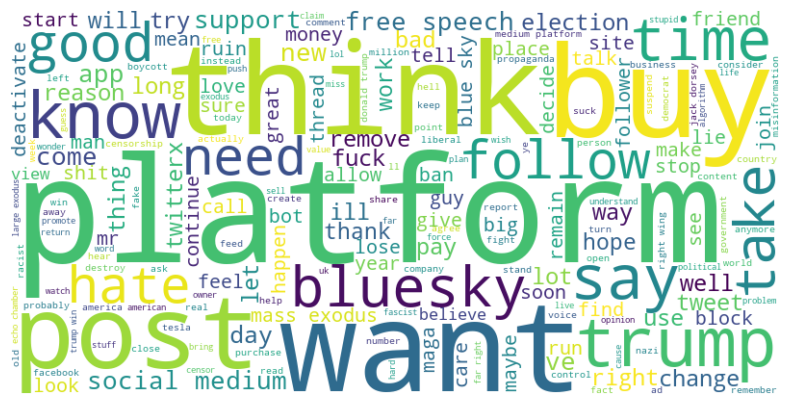

In [ ]:
liste = [token for ligne in df_clean['tokens'] for token in ligne if len(token) > 1]
generate_wordcloud(liste)

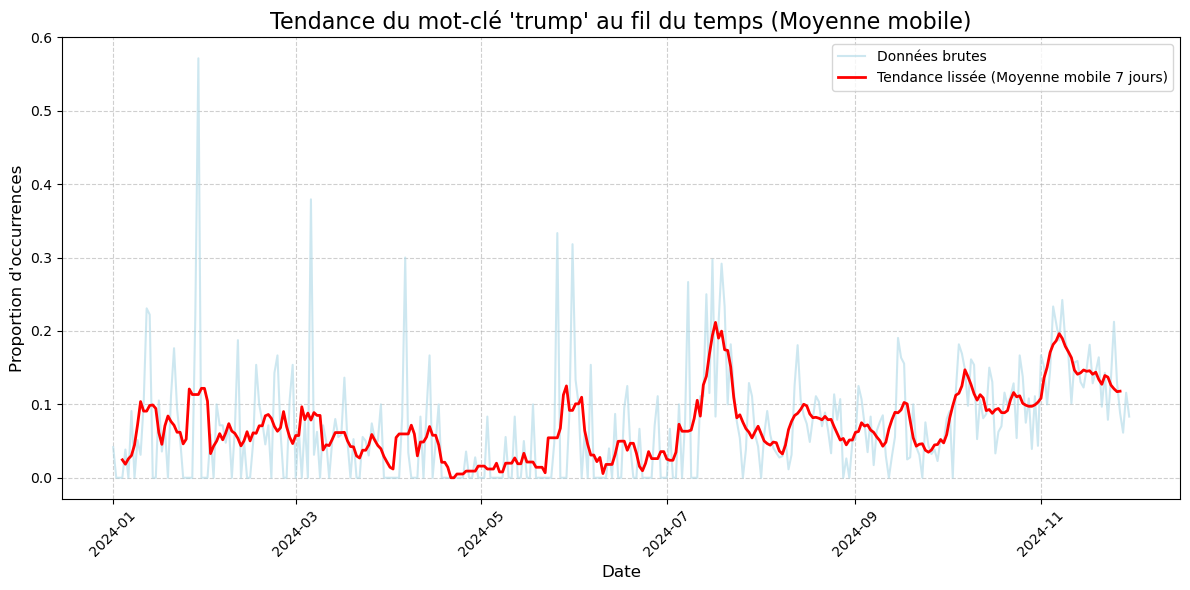

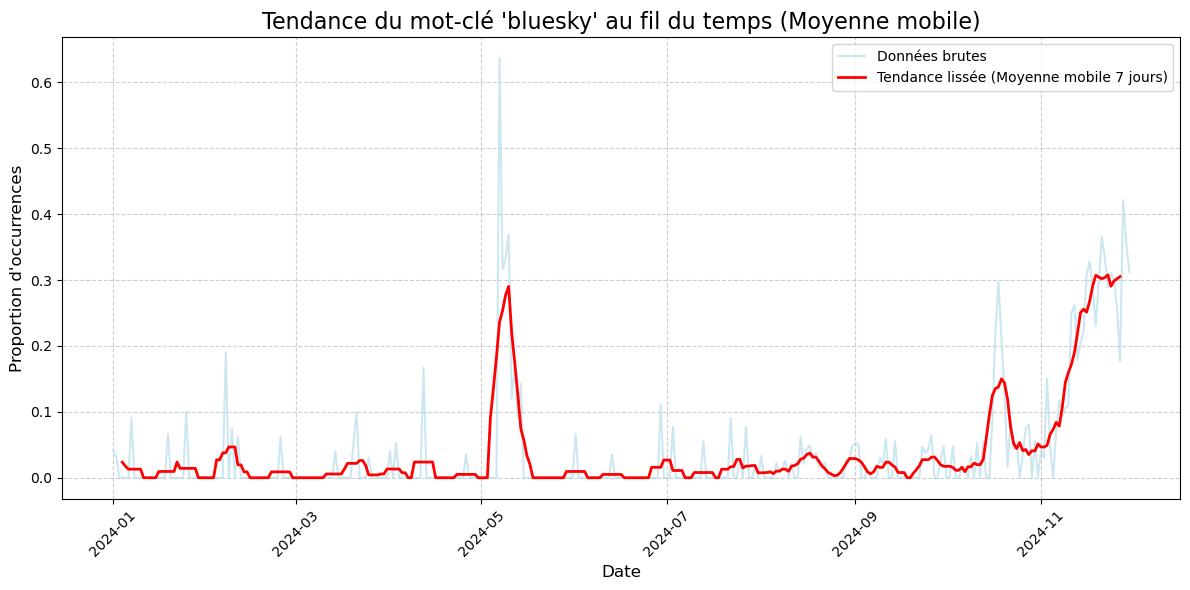

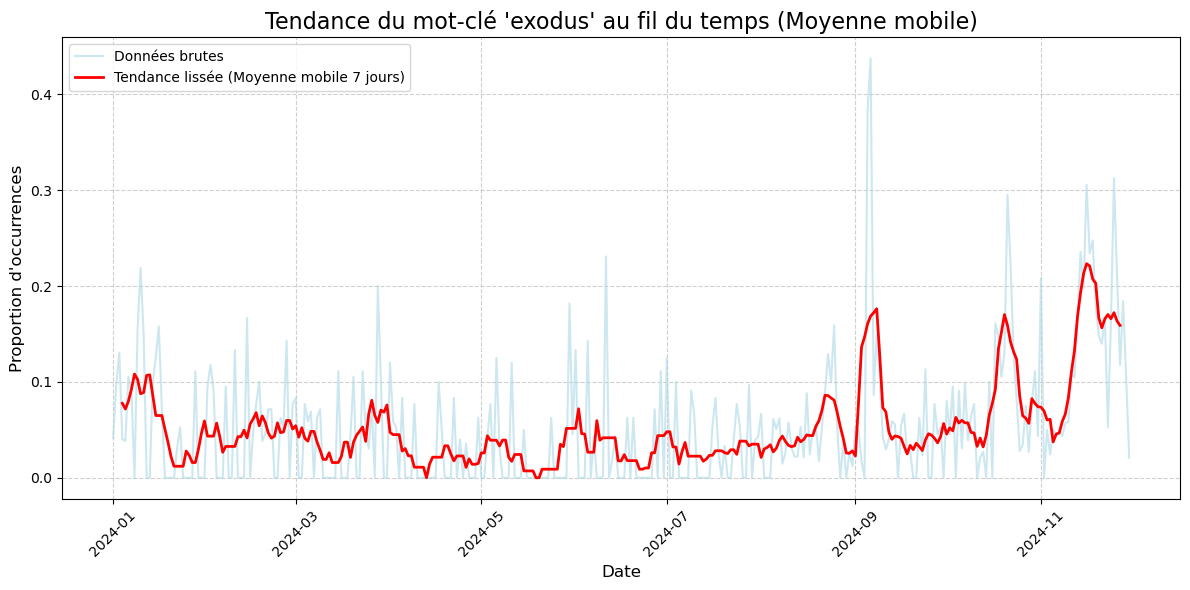

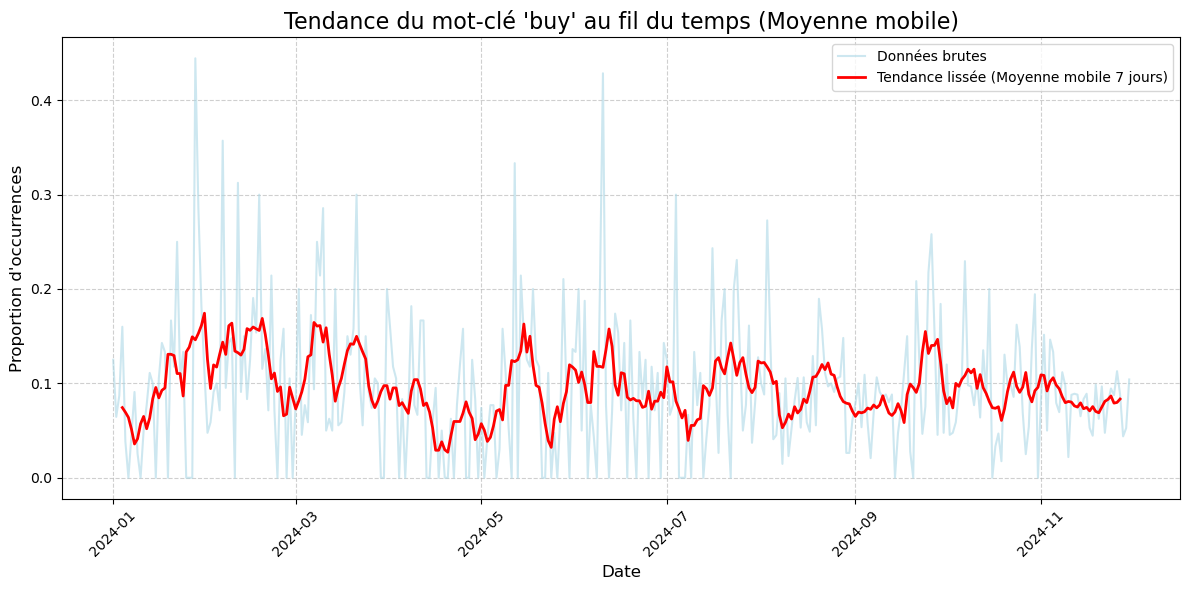

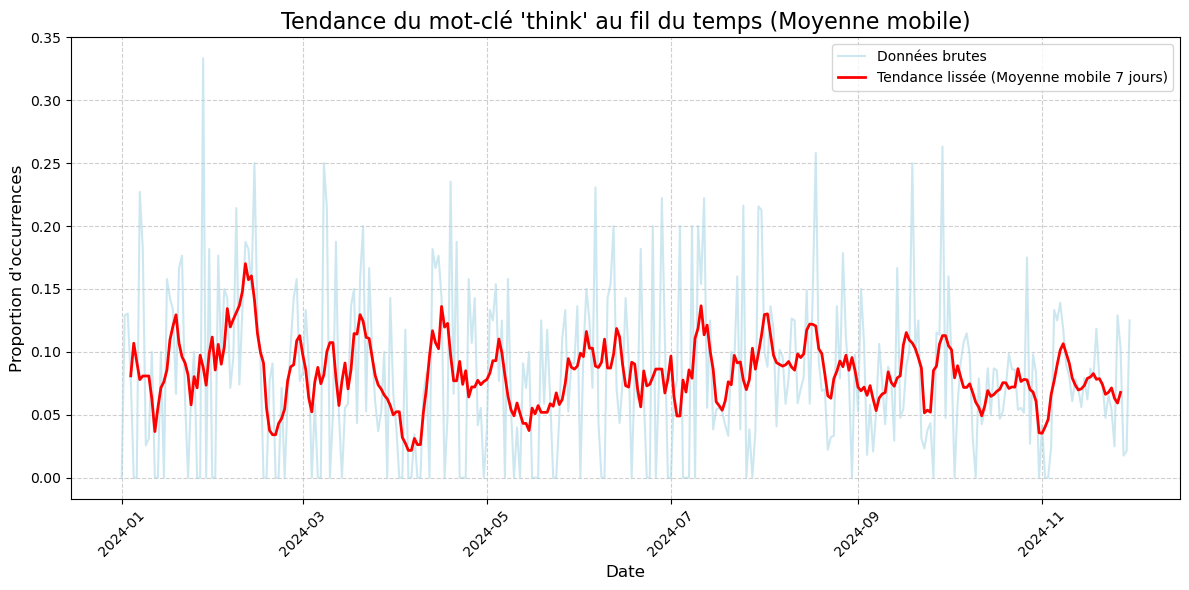

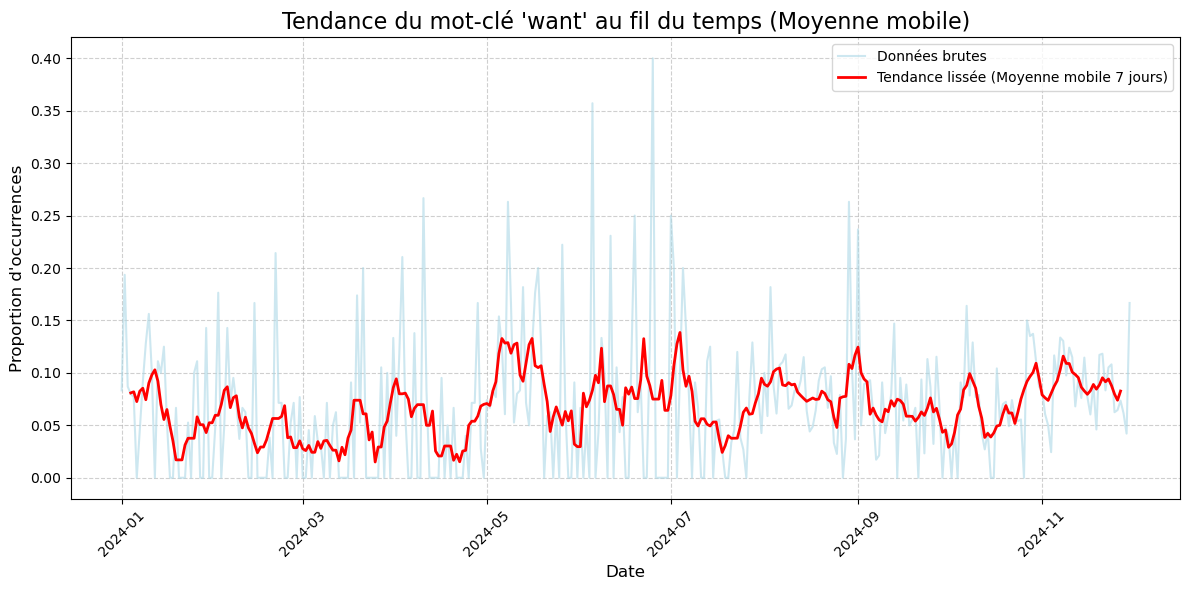

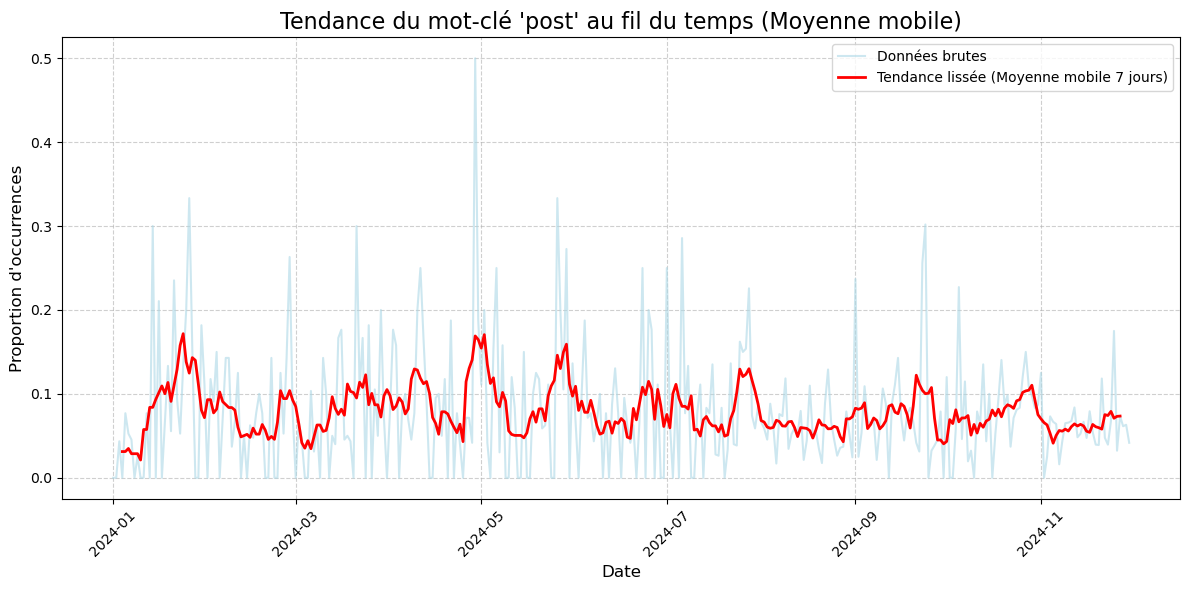

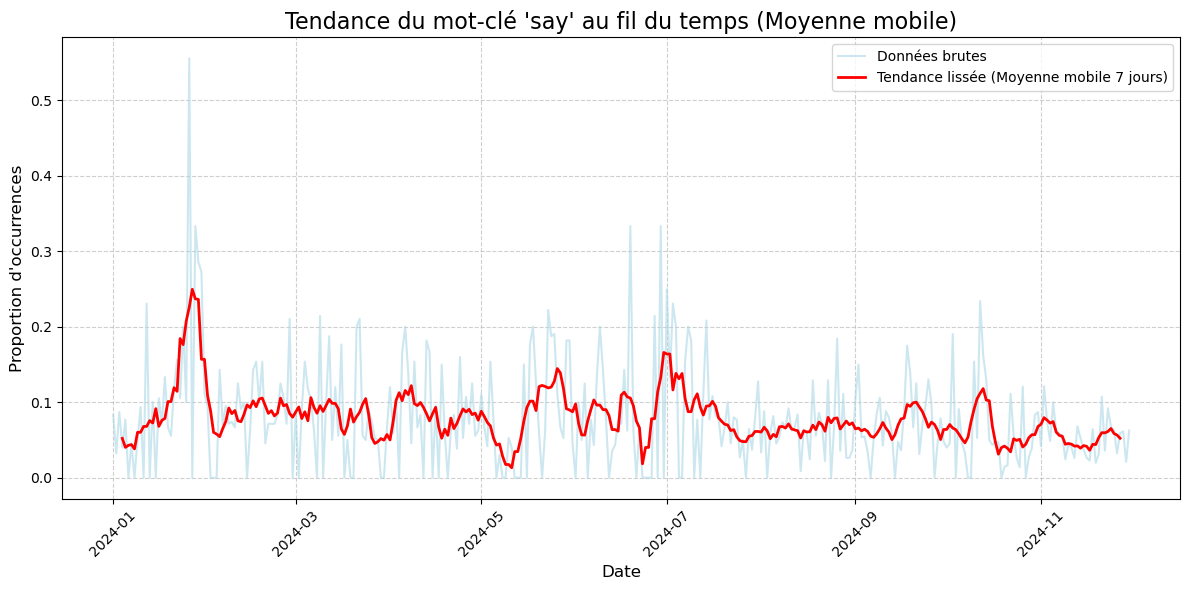

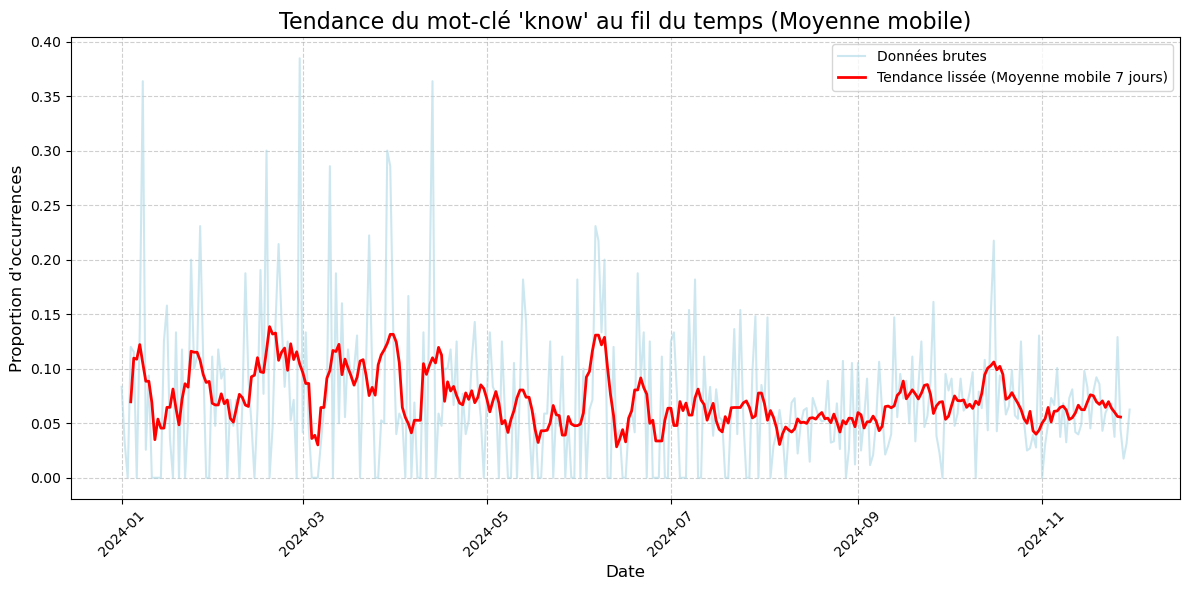

In [8]:
df['ConvertedDate'] = pd.to_datetime(df['ConvertedDate'], errors='coerce')
fd = pd.DataFrame(fdist.most_common(10), columns = ["Word","Frequency"]).drop([0]).reindex()

for word in fd['Word']:
    mot_cle = word
    df['mention'] = df['tokens'].apply(lambda tokens: mot_cle in tokens)
    total_tweets = df.groupby(df['ConvertedDate'].dt.date).size()
    occurrences = df[df['mention']].groupby(df['ConvertedDate'].dt.date).size()
    all_days = pd.date_range(start='2024-01-01', end='2024-11-30')
    occurrences = occurrences.reindex(all_days, fill_value=0)
    proportion = occurrences / total_tweets

    proportion = proportion.reindex(all_days, fill_value=0)

    rolling_window = 7  
    rolling_mean = proportion.rolling(window=rolling_window, center=True).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(proportion.index, proportion.values, label='Données brutes', color='#ADD8E6', alpha=0.6)
    plt.plot(proportion.index, rolling_mean, label=f'Tendance lissée (Moyenne mobile {rolling_window} jours)', color='red', linewidth=2)

# Ajouter des détails au graphique
    plt.title(f"Tendance du mot-clé '{word}' au fil du temps (Moyenne mobile)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Proportion d'occurrences", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Pour les 10 mots les plus fréquents, on a calculé dans le code ci-dessus la proportion de tweets les mentionnant par jour parmi tous les tweets observés, puis on a calculé la moyenne mobile sur 7 jours de cette proportion, afin de lisser le graphique et voir se dégager une tendance. On utilise pour ce faire la fonction *rolling()* de `pandas`, et on a observé une tendance à la hausse des tweets mentionnant les mots *bluesky*, *trump* et *exodus*, ce qui laisse à penser que le sujet devient de plus en 
On voit également se dégager des pics de popularité de certains mots, par exemple le mot *bluesky* intervient en moyenne dans 30% des tweets en début mai 2024.

Les codes plus bas effectuent la même analyse mais en comparant les occurrences de mots dans les tweets dits violents et celles dans les tweets dits non violents

**Limites de cette approche** : L'analyse fréquentielle comporte des limites, notamment le fait que les mots sont extraits de leur contexte et qu'on n'a pas accès à l'avis que le tweet exprime sur fait de quitter Twitter (*bluesky* peut alors être mis en avant ou au contraire critiqué). 

In [15]:
df_non_violent = df[df['violence_prédite'] == 0]
df_violent = df[df['violence_prédite'] == 1]

liste_non_violent = []
for ligne in df_non_violent['tokens']:
    liste_non_violent = liste_non_violent + ligne
liste_non_violent = [token for token in liste_non_violent if len(token) > 1]

fdist_non_violent = FreqDist(liste_non_violent)
fd_non_violent = pd.DataFrame(fdist_non_violent.most_common(30), columns = ["Word","Frequency"]).drop([0]).reindex()
fig = px.bar(fd_non_violent, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(240,128,128)',marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.8)
fig.show()


liste_violent = []
for ligne in df_violent['tokens']:
    liste_violent = liste_violent + ligne
liste_violent = [token for token in liste_violent if len(token) > 1]

fdist_violent = FreqDist(liste_violent)
fd_violent = pd.DataFrame(fdist_violent.most_common(30), columns = ["Word","Frequency"]).drop([0]).reindex()
fig = px.bar(fd_violent, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(240,128,128)',marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.8)
fig.show()

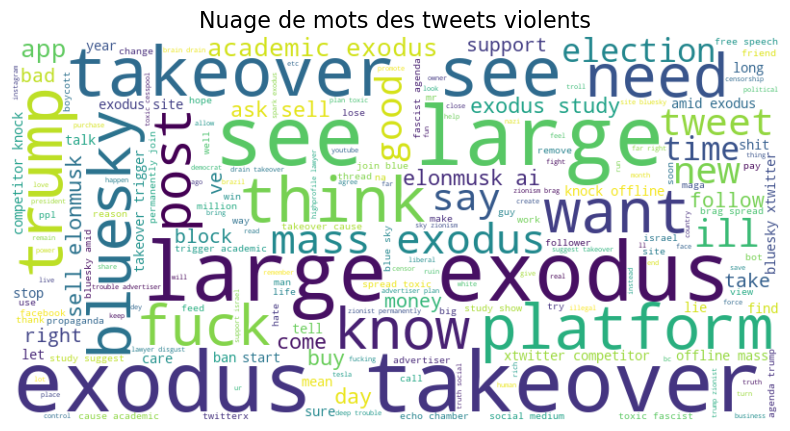

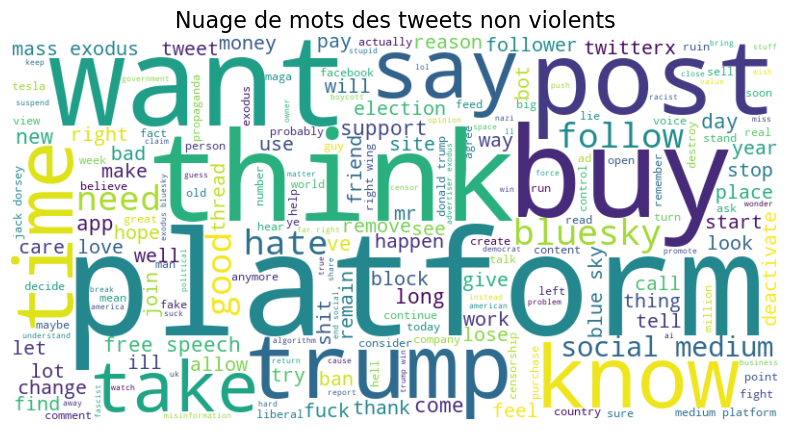

In [16]:
# Créer un Wordcloud pour les tweets violents et non violents
text_violent = ' '.join(liste_violent)
text_non_violent = ' '.join(liste_non_violent)

# Wordcloud pour les tweets violents
wordcloud_violent = WordCloud(width=800, height=400, background_color='white').generate(text_violent)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_violent, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des tweets violents", fontsize=16)
plt.show()

# Wordcloud pour les tweets non violents
wordcloud_non_violent = WordCloud(width=800, height=400, background_color='white').generate(text_non_violent)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_violent, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des tweets non violents", fontsize=16)
plt.show()


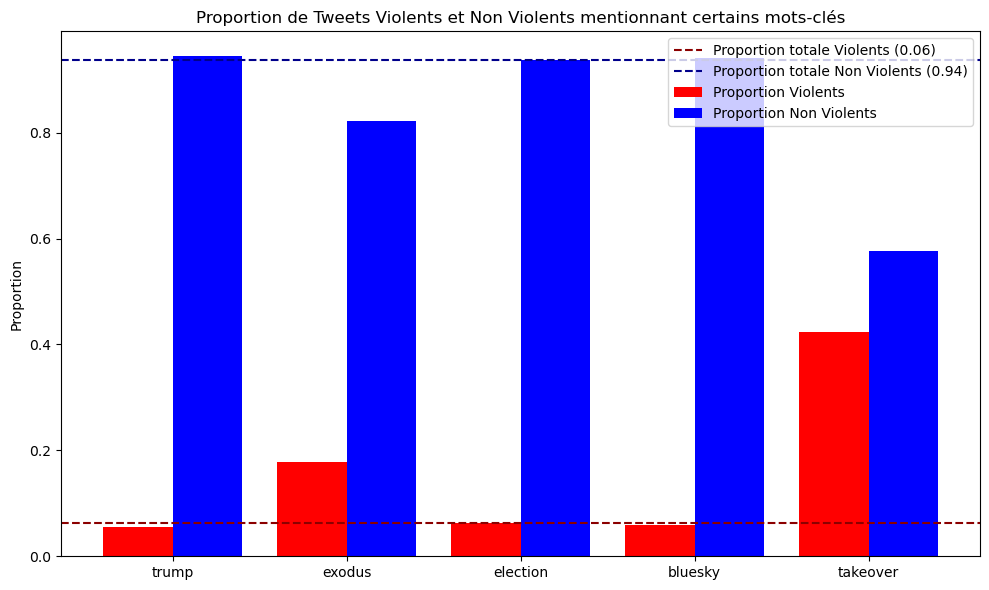

In [17]:
#on va sélectionner certains mots et regarder la proportion de tweets dits violents et non violents 
# qui mentionnent ces mots, cela en tenant compte de la proportion totale de tweets violents et 
#non violents

import matplotlib.pyplot as plt
import numpy as np

# Liste des mots-clés
keywords = ["trump", "exodus", "election", "bluesky","takeover"]

# Initialisation des résultats pour les proportions
proportions_violent = []
proportions_non_violent = []

# Calcul des proportions pour chaque mot-clé
for mot_cle in keywords:
    # Filtrer les tweets mentionnant le mot-clé
    df_mention_mot_cle = df[df['tokens'].apply(lambda tokens: mot_cle.lower() in tokens)]
    
    # Calcul des proportions
    proportion_violent = df_mention_mot_cle[df_mention_mot_cle['violence_prédite'] == 1].shape[0] / df_mention_mot_cle.shape[0]
    proportion_non_violent = df_mention_mot_cle[df_mention_mot_cle['violence_prédite'] == 0].shape[0] / df_mention_mot_cle.shape[0]
    
    # Ajouter les résultats
    proportions_violent.append(proportion_violent)
    proportions_non_violent.append(proportion_non_violent)

# Calcul des proportions totales de tweets violents et non violents
total_violent = df[df['violence_prédite'] == 1].shape[0]
total_non_violent = df[df['violence_prédite'] == 0].shape[0]
proportion_total_violent = total_violent / (total_violent + total_non_violent)
proportion_total_non_violent = total_non_violent / (total_violent + total_non_violent)

# Création du graphique
x = np.arange(len(keywords))  # Position des mots-clés sur l'axe X

fig, ax = plt.subplots(figsize=(10, 6))

# Barres pour les proportions de tweets violents
ax.bar(x - 0.2, proportions_violent, 0.4, label='Proportion Violents', color='red')

# Barres pour les proportions de tweets non violents
ax.bar(x + 0.2, proportions_non_violent, 0.4, label='Proportion Non Violents', color='blue')

# Ajouter les lignes horizontales pour les proportions totales
ax.axhline(y=proportion_total_violent, color='darkred', linestyle='--', label=f'Proportion totale Violents ({proportion_total_violent:.2f})')
ax.axhline(y=proportion_total_non_violent, color='darkblue', linestyle='--', label=f'Proportion totale Non Violents ({proportion_total_non_violent:.2f})')

# Ajouter des détails au graphique
ax.set_xticks(x)
ax.set_xticklabels(keywords)
ax.set_ylabel('Proportion')
ax.set_title('Proportion de Tweets Violents et Non Violents mentionnant certains mots-clés')
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()